In [1]:
#%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
data = np.load('data.npy')

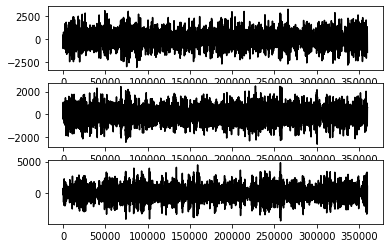

In [2]:
fig,ax=plt.subplots(3)
ax[0].plot(data[0,0,:],'k-')
ax[1].plot(data[0,1,:],'k-')
ax[2].plot(data[0,2,:],'k-')

In [3]:
data_not_scaled = data[0,0,:].reshape(-1,1)

In [4]:
# Library for neural networks
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [5]:
l = len(data_not_scaled)
l

360000

In [7]:
# Time window to define the number of features in each row
t_w_1 = 4

# Define a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Compute in-sample and out-of-sample size
#train_size_1 = 124-8-t_w_1
#vali_size = 8

train_size_1 = int(l*0.7)-8-t_w_1
vali_size = int(l*0.1)

# Fitting the scaler
fitted_transformer_1 = scaler.fit(data_not_scaled[:train_size_1+t_w_1])

# Transforming using trained scaler
data_scaled_1 = fitted_transformer_1.transform(data_not_scaled)

In [8]:
# Pre-allocation
Xall1, Yall1 = [], []
Xall_not_scaled, Yall_not_scaled = [], []

# Use each rolling window as a row in the data matrix 
for i in range(t_w_1, len(data_scaled_1)):
    Xall1.append(data_scaled_1[i-t_w_1:i, 0]) # Access the accuracy
    Xall_not_scaled.append(data_not_scaled[i-t_w_1:i, 0]) # Training NN
    Yall1.append(data_scaled_1[i, 0])
    Yall_not_scaled.append(data_not_scaled[i, 0])

# Convert them from list to numpy array
Xall1 = np.array(Xall1)
Yall1 = np.array(Yall1)


Xall_not_scaled = np.array(Xall_not_scaled)
Yall_not_scaled = np.array(Yall_not_scaled)

# HERE I JUST JUMP SAMPLE TO AVOID TARGET APPEAR IN FEATURES
Xall1 = np.array(Xall1)[::5]
Yall1 = np.array(Yall1)[::5]
Xall_not_scaled  =  Xall_not_scaled[::5]
Yall_not_scaled  =  Yall_not_scaled[::5]

In [ ]:
# Training data
Xtrain = Xall1[:train_size_1, :]
Ytrain = Yall1[:train_size_1]

# Validation data
Xval = Xall1[-vali_size:, :]
Yval = Yall1[-vali_size:]


Xtrain.shape,Xval.shape

In [63]:
# For time series and LSTM layer we need to reshape into 3D array 
time_window = 4
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], time_window,1))
Xval = np.reshape(Xval, (Xval.shape[0], time_window,1))

In [66]:
model = Sequential()
model.add(LSTM(units=8,input_shape = (time_window,1))) 
model.add(Dense(units=1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 8)                 320       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Use the following code to control the randomness in building NN
# reference: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(0)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(0)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(0)

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)

In [70]:
model.fit(Xtrain, Ytrain, 
          batch_size = 100,             
          epochs = 5,               
          validation_split = 0.1, 
          shuffle = False,
          verbose = 1, 
          callbacks = [early_stop])

Epoch 1/5
2268/2268 [==============================] - 6s 3ms/step - loss: 3.7709e-06 - val_loss: 2.2924e-07
Epoch 2/5
2268/2268 [==============================] - 6s 3ms/step - loss: 6.9353e-07 - val_loss: 2.4564e-07
Epoch 3/5
2268/2268 [==============================] - 6s 3ms/step - loss: 1.3810e-06 - val_loss: 9.9377e-07
Epoch 4/5
2268/2268 [==============================] - 7s 3ms/step - loss: 1.3066e-06 - val_loss: 1.1030e-06
Epoch 5/5
2268/2268 [==============================] - 7s 3ms/step - loss: 1.2276e-06 - val_loss: 8.1267e-07


In [71]:
# Predicting
train_size = Xtrain.shape[0]
test_size = Xval.shape[0]
allPredict = model.predict(np.reshape(Xall1, (Xall1.shape[0],time_window,1)))

#Transforming to original scale
allPredict_original_scale = scaler.inverse_transform(allPredict)
allPredictPlot = np.empty_like(data_scaled_1)
allPredictPlot[:, :] = np.nan
allPredictPlot[time_window:, :] = allPredict_original_scale

11250/11250 [==============================] - 10s 881us/step


<IPython.core.display.Javascript object>


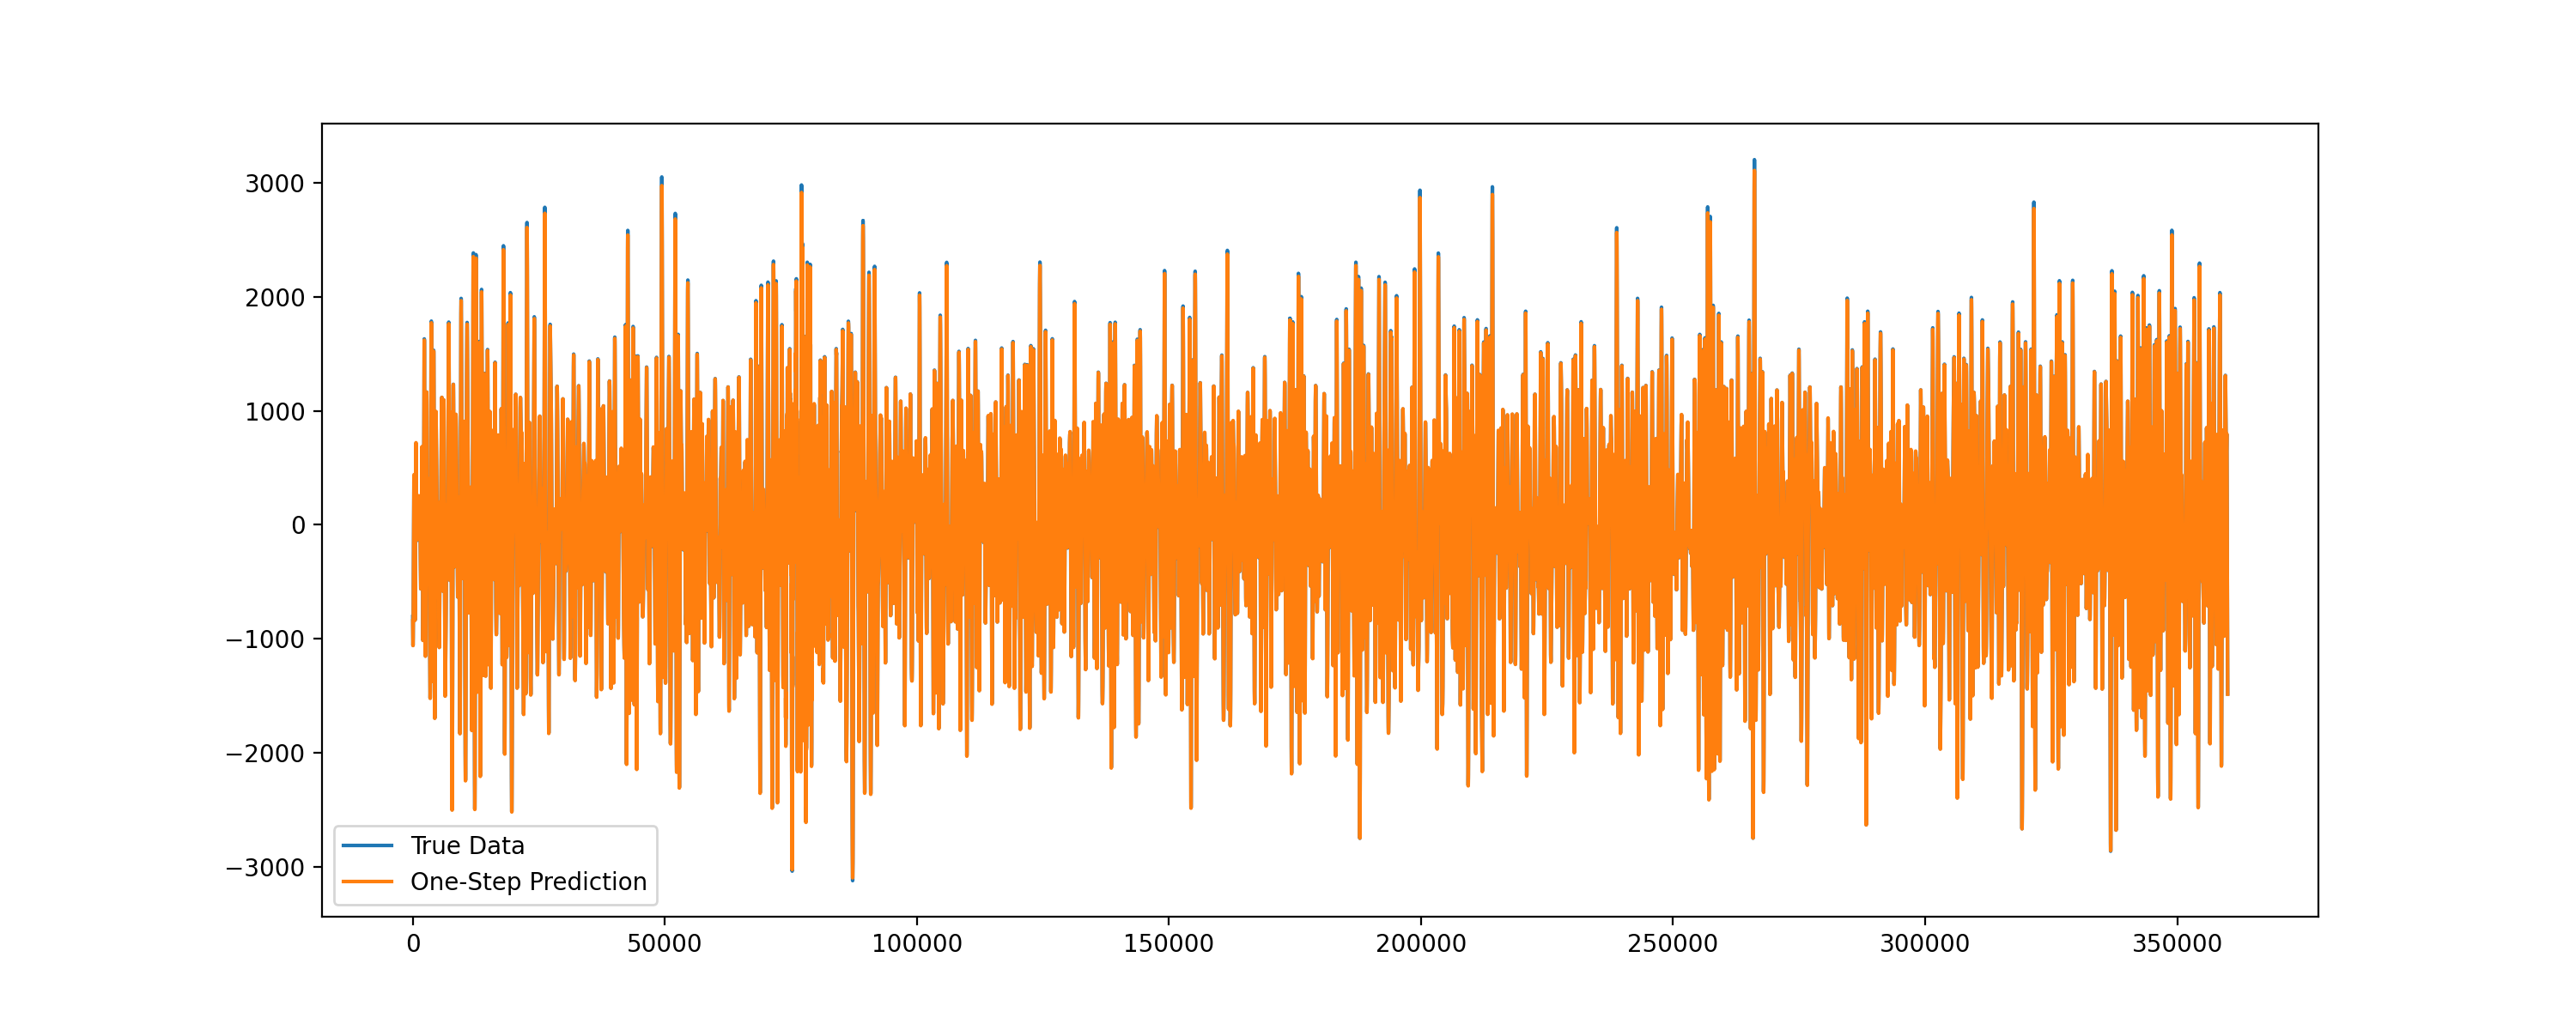

In [72]:
# Plot true and in-sample forecast values
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data_scaled_1), label='True Data')
plt.plot(allPredictPlot, label='One-Step Prediction')
plt.legend()
plt.show()

In [73]:
# Checking training and test score
trainScore = np.sqrt(mean_squared_error(Ytrain, allPredict[:train_size,0]))
testScore = np.sqrt(mean_squared_error(Yval, allPredict[-test_size:,0]))

print('Training Data RMSE: {0:.2f}'.format(trainScore))
print('Validation Data RMSE: {0:.2f}'.format(testScore))

Training Data RMSE: 0.00
Validation Data RMSE: 0.00
